In [1]:
#Dataset: https://www.kaggle.com/datasets/colewelkins/cardiovascular-disease

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
cardio = pd.read_csv('https://raw.githubusercontent.com/curdferguson/data622/main/datasets/cardio_data_processed.csv')
cardio = cardio.drop(columns=['id', 'age_years']).rename(columns={'bp_category':'bp_category_label', 'bp_category_encoded':'bp_category'})

In [4]:
cardio.loc[cardio['bp_category_label'] == 'Normal', 'bp_category'] = 0
cardio.loc[cardio['bp_category_label'] == 'Elevated', 'bp_category'] = 1
cardio.loc[cardio['bp_category_label'] == 'Hypertension Stage 1', 'bp_category'] = 2
cardio.loc[cardio['bp_category_label'] == 'Hypertension Stage 2', 'bp_category'] = 3
cardio['bp_category'] = cardio['bp_category'].astype(int)

In [5]:
print(cardio.columns)
display(cardio.head(5))

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi', 'bp_category_label',
       'bp_category'],
      dtype='object')


age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0  18393       2     168    62.0    110     80            1     1      0   
1  20228       1     156    85.0    140     90            3     1      0   
2  18857       1     165    64.0    130     70            3     1      0   
3  17623       2     169    82.0    150    100            1     1      0   
4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio        bmi     bp_category_label  bp_category  
0     0       1       0  21.967120  Hypertension Stage 1            2  
1     0       1       1  34.927679  Hypertension Stage 2            3  
2     0       0       1  23.507805  Hypertension Stage 1            2  
3     0       1       1  28.710479  Hypertension Stage 2            3  
4     0       0       0  23.011177                Normal            0

In [6]:
display(cardio[(cardio.isnull()) | (cardio.isna())].sum())

age                  0.0
gender               0.0
height               0.0
weight               0.0
ap_hi                0.0
ap_lo                0.0
cholesterol          0.0
gluc                 0.0
smoke                0.0
alco                 0.0
active               0.0
cardio               0.0
bmi                  0.0
bp_category_label      0
bp_category          0.0
dtype: object

In [7]:
cat_cols = [1] + list(range(6, 12)) + [13, 14]
cat_cols = cardio.columns[cat_cols]
for i in cat_cols:
    cardio.loc[:, i] = pd.Categorical(cardio.loc[:, i])

In [8]:
display(cardio.describe())

age        height        weight         ap_hi         ap_lo  \
count  68205.000000  68205.000000  68205.000000  68205.000000  68205.000000   
mean   19462.667737    164.372861     74.100688    126.434924     81.263925   
std     2468.381854      8.176756     14.288862     15.961685      9.143985   
min    10798.000000     55.000000     11.000000     90.000000     60.000000   
25%    17656.000000    159.000000     65.000000    120.000000     80.000000   
50%    19700.000000    165.000000     72.000000    120.000000     80.000000   
75%    21323.000000    170.000000     82.000000    140.000000     90.000000   
max    23713.000000    250.000000    200.000000    180.000000    120.000000   

                bmi  
count  68205.000000  
mean      27.510513  
std        6.026497  
min        3.471784  
25%       23.875115  
50%       26.346494  
75%       30.116213  
max      298.666667

In [9]:
cardio.loc[cardio['cardio'] == 0, 'cardio_label'] = 'Absence'
cardio.loc[cardio['cardio'] == 1, 'cardio_label'] = 'Presence'

cardio['cardio_label'] = pd.Categorical(cardio['cardio_label'], 
                                    ordered=True)


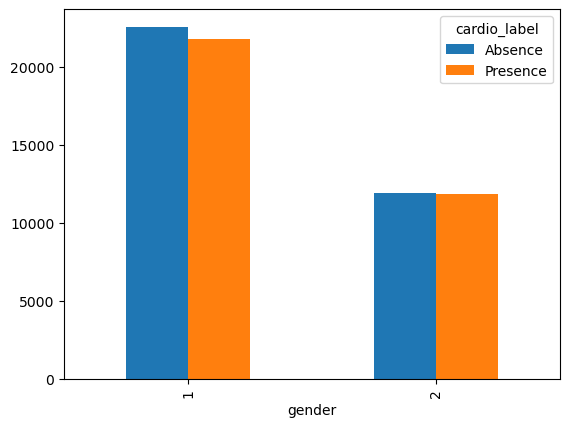

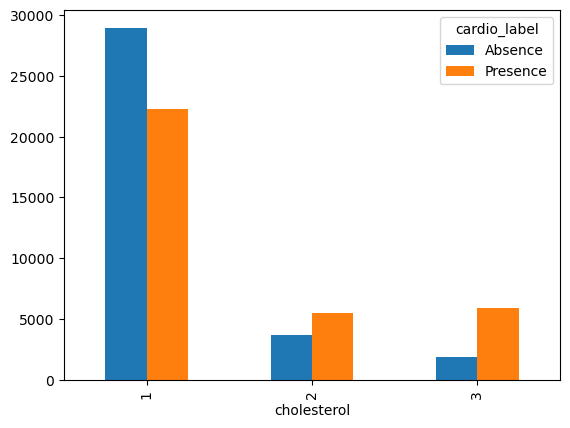

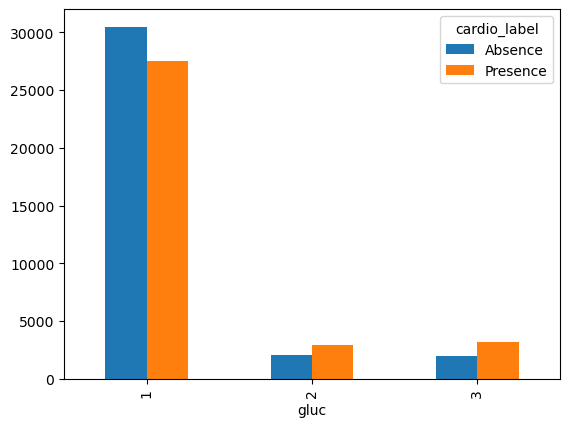

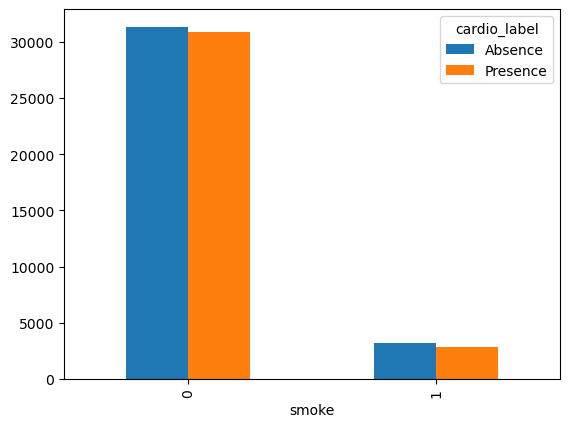

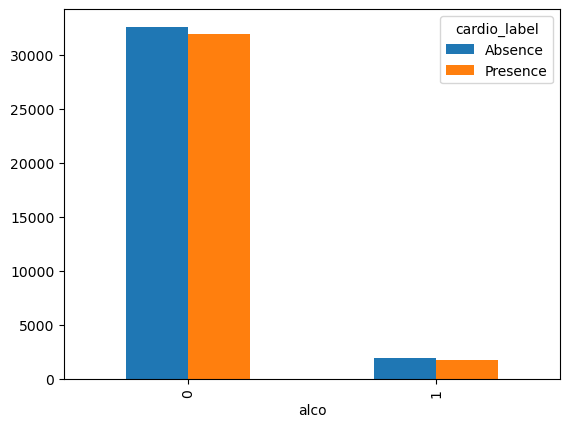

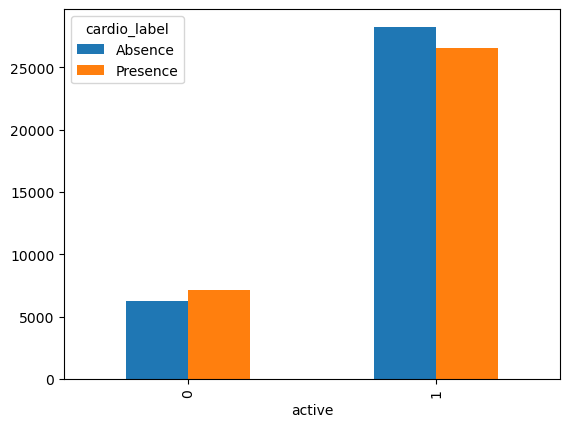

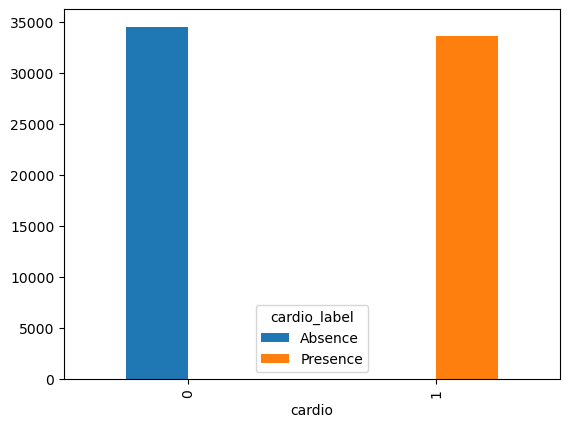

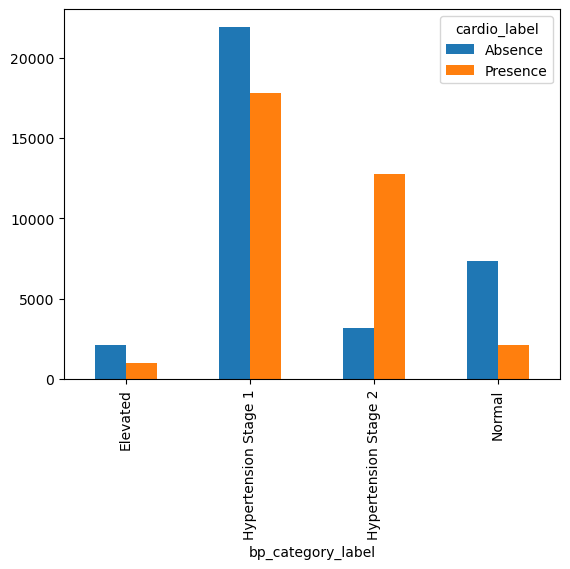

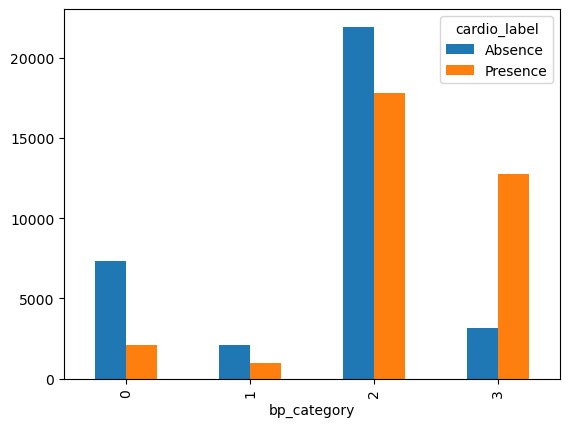

In [10]:
import plotly.express as px

#fig = px.box(cardio, 
#                y=cardio.columns[0], 
#                color='cardio_label', 
#                category_orders={
#                    'cardio_label': ['Absence', 'Presence']
#                    }
#            )
#fig.update_layout(title=f"{cardio.columns[0]}")
#fig.update_yaxes(title=None)
#fig.show()

for i in [i for i in cardio.columns if i not in cat_cols]:
    fig = px.box(cardio, 
                    y=cardio[i], 
                    color='cardio_label', 
                    category_orders={
                        'cardio_label': ['Absence', 'Presence']
                        }
                )
    fig.update_layout(title=f"{i}")
    fig.update_yaxes(title=None)
    fig.show()

for i in [i for i in cardio.columns if i in cat_cols]:
    CrosstabResult=pd.crosstab(index=cardio[i],columns=cardio['cardio_label'])
    CrosstabResult.plot.bar()



### Split and Scale the data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
X = cardio.loc[:, [col for col in cardio if col not in ['cardio', 'cardio_label', 'bp_category_label']]].values
y = cardio['cardio'].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

sc = StandardScaler()

X = sc.fit_transform(X)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression 
  
logreg = LogisticRegression() 
logreg.fit(X_train, y_train)

logreg_predict = logreg.predict(X_test)

In [15]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
)

results_df = pd.DataFrame({"Actual": y_test, "Predicted": logreg_predict})
display(results_df[results_df["Actual"] != results_df["Predicted"]].head(10))

logreg_accuracy = accuracy_score(logreg_predict, y_test)
f1 = f1_score(logreg_predict, y_test, average="weighted")

print("Accuracy: ", logreg_accuracy)
print("F1 Score: ", f1)

Actual  Predicted
2       1          0
7       0          1
16      0          1
18      0          1
19      1          0
21      1          0
40      1          0
42      0          1
48      0          1
49      0          1

Accuracy:  0.7297677691766362
F1 Score:  0.7309707811895337


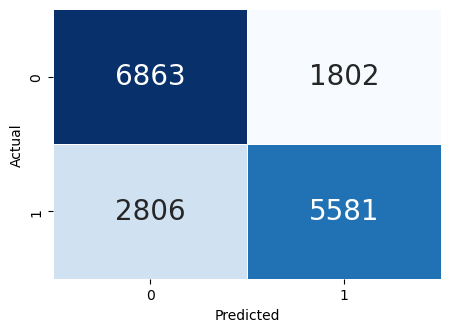

In [16]:
import seaborn as sns

cm = confusion_matrix(y_test, logreg_predict) 

plt.figure(figsize = (5, 3.5))
ax = sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=".0f", annot_kws={"size": 20}, linewidth=0.5)
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression()
model.fit(X, y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

logreg_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(logreg_scores))

NameError: name 'cross_val_score' is not defined

### K-Nearest Neighbors

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

knn_predict = knn.predict(X_test)

In [19]:
results_df = pd.DataFrame({"Actual": y_test, "Predicted": knn_predict})
display(results_df[results_df["Actual"] != results_df["Predicted"]].head(10))

knn_accuracy = accuracy_score(knn_predict, y_test)
f1 = f1_score(knn_predict, y_test, average="weighted")

print("Accuracy: ", knn_accuracy)
print("F1 Score: ", f1)

Actual  Predicted
4       1          0
7       0          1
16      0          1
18      0          1
19      1          0
22      1          0
23      0          1
24      1          0
28      0          1
38      0          1

Accuracy:  0.6801548205489092
F1 Score:  0.6802346103114131


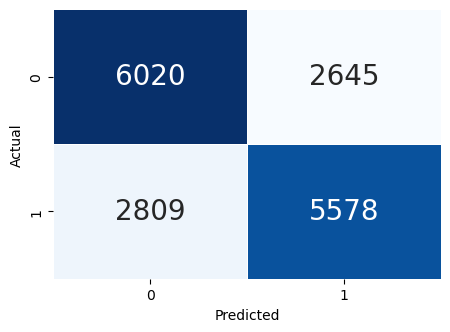

In [20]:
cm = confusion_matrix(y_test, knn_predict) 

plt.figure(figsize = (5, 3.5))
ax = sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=".0f", annot_kws={"size": 20}, linewidth=0.5)
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

In [21]:
k_values = [i for i in range(1,31)]
scores = []

sc = StandardScaler()

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

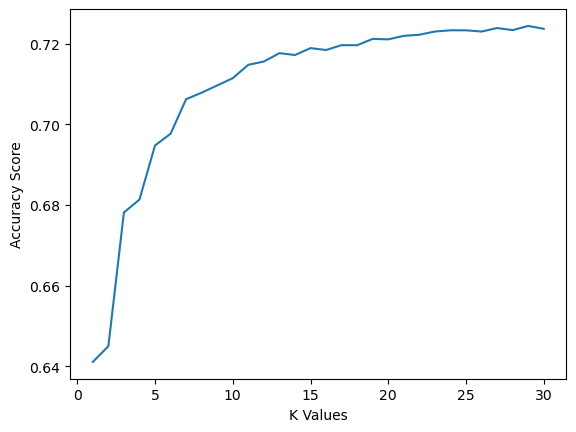

In [22]:
sns.lineplot(x = k_values, y = scores)
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [23]:
chosen_k = 15

model = KNeighborsClassifier(n_neighbors=chosen_k)
model.fit(X, y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

knn_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(knn_scores))

0.7184565712838693


### Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_predict = gnb.predict(X_test)

In [25]:
results_df = pd.DataFrame({"Actual": y_test, "Predicted": gnb_predict})
display(results_df[results_df["Actual"] != results_df["Predicted"]].head(10))

gnb_accuracy = accuracy_score(gnb_predict, y_test)
f1 = f1_score(gnb_predict, y_test, average="weighted")

print("Accuracy: ", gnb_accuracy)
print("F1 Score: ", f1)

Actual  Predicted
2       1          0
9       1          0
16      0          1
18      0          1
19      1          0
21      1          0
40      1          0
42      0          1
48      0          1
57      1          0

Accuracy:  0.7149307999061694
F1 Score:  0.7170084029921596


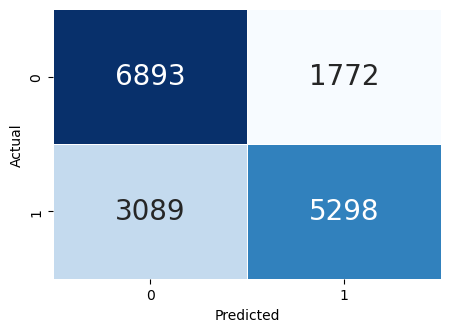

In [26]:
cm = confusion_matrix(y_test, gnb_predict) 

plt.figure(figsize = (5, 3.5))
ax = sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=".0f", annot_kws={"size": 20}, linewidth=0.5)
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

In [27]:
from sklearn.model_selection import RepeatedStratifiedKFold

model = GaussianNB()
model.fit(X, y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

gnb_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(gnb_scores))


0.714756894748737


### Linear Discriminant Analysis

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
lda.fit(X_train, y_train)
lda_predict = lda.predict(X_test)

In [29]:
results_df = pd.DataFrame({"Actual": y_test, "Predicted": lda_predict})
display(results_df[results_df["Actual"] != results_df["Predicted"]].head(10))

lda_accuracy = accuracy_score(lda_predict, y_test)
f1 = f1_score(lda_predict, y_test, average="weighted")

print("Accuracy: ", lda_accuracy)
print("F1 Score: ", f1)

Actual  Predicted
2       1          0
7       0          1
16      0          1
18      0          1
19      1          0
21      1          0
40      1          0
42      0          1
48      0          1
49      0          1

Accuracy:  0.7284189537884119
F1 Score:  0.7299417253609206


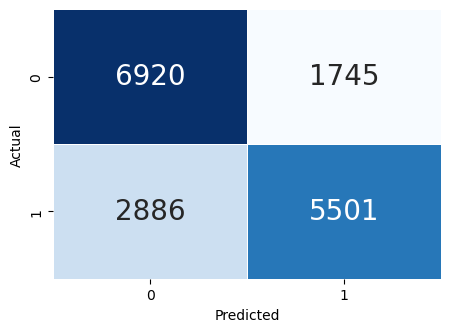

In [30]:
cm = confusion_matrix(y_test, lda_predict) 

plt.figure(figsize = (5, 3.5))
ax = sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=".0f", annot_kws={"size": 20}, linewidth=0.5)
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

In [31]:
model = LDA()
model.fit(X, y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

lda_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(lda_scores))

0.7257483050375021


### Quadratic Discriminant Analysis

In [32]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

qda = QDA()
qda.fit(X_train, y_train)
qda_predict = qda.predict(X_test)

In [33]:
results_df = pd.DataFrame({"Actual": y_test, "Predicted": qda_predict})
display(results_df[results_df["Actual"] != results_df["Predicted"]].head(10))

qda_accuracy = accuracy_score(qda_predict, y_test)
f1 = f1_score(qda_predict, y_test, average="weighted")

print("Accuracy: ", qda_accuracy)
print("F1 Score: ", f1)

Actual  Predicted
3       1          0
16      0          1
19      1          0
21      1          0
32      1          0
40      1          0
42      0          1
49      0          1
50      1          0
54      1          0

Accuracy:  0.6893033075299085
F1 Score:  0.6949560240848334


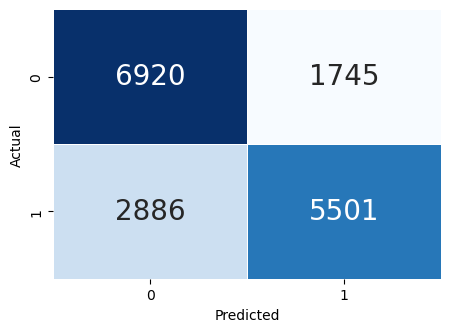

In [34]:
cm = confusion_matrix(y_test, lda_predict) 

plt.figure(figsize = (5, 3.5))
ax = sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=".0f", annot_kws={"size": 20}, linewidth=0.5)
ax.set(xlabel="Predicted", ylabel="Actual")
plt.show()

In [35]:
model = QDA()
model.fit(X, y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

qda_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(qda_scores))

0.692055857055786


### Compare Models

In [36]:
scores_df = pd.DataFrame({
    'Logistic Regression':[np.mean(logreg_scores)],
    'K Nearest Neighbors (k=15)':[np.mean(knn_scores)],
    'Gaussian Naive Bayes':[np.mean(gnb_scores)],
    'Linear Discriminant Analysis':[np.mean(lda_scores)],
    'Quadratic Discriminant Analysis':[np.mean(qda_scores)]
}
)

scores_df.index = ['Mean Accuracy']
display(scores_df)

NameError: name 'logreg_scores' is not defined